# 18장 신경망

인공 신경망은 뇌를 묘사한 예측 모델이다.
인공적인 뉴런으로 구성되어 있고, 입력값을 받아 계산을 수행한다.

대부분의 신경망은 블랙박스이기 때문에 그 속을 들여다 본들 어떻게 문제를 풀고 있는지 이해할 수 없고,  
큰 신경망은 학습시키기도 어렵기 때문에 초보 데이터 과학자가 문제를 해결하려 할 때 활용하기에는 좋은 방법이 아니다.

하지만 언젠가 인공지능을 만들어 기술적 특이점을 앞당기고자 할 때는 신경망도 좋은 선택이라고 할 수 있다.

In [113]:
from collections import Counter
from functools import partial
from linear_algebra import dot
import math, random
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

## 18.1 퍼셉트론(perceptron)

퍼셉트론은 n개의 이진수가 하나의 뉴런을 통과해서 가중합이 0보다 크면 활성화 되는 가장 간단한 신경망 구조이다.

In [2]:
def step_function(x):
    return 1 if x >= 0 else 0

def perceptron_output(weights, bias, x):
    """퍼셉트론이 활성화 되면 1을, 아니면 0을 반환"""
    return step_function(dot(weights, x) + bias)

퍼셉트로는 초평면(hyperplane)으로 구분되는 두 개의 공간을 분리시키는 역할을 한다.

dot(weights, x) + bias == 0

여기에서 weights만 잘 선택하면 퍼셉트론으로도 여러가지 간단한 문제를 풀 수 있다.

#### AND, OR 게이트
2개의 입력값에 대한 AND와 OR 연산을 하는 게이트를 만들 수 있다.

AND GATE  
입력값이 [1, 1] 일때, $2 + 2 - 3 = 1$  
입력값이 [1, 0] 일때, $2 + 0 - 3 = -1$

In [3]:
weights = [2, 2]
bias = [-3, -1] #[AND, OR]

perceptron_output(weights, bias[0], [1, 0])

0

In [4]:
import numpy as np

x = [[0,0], [0,1], [1,0], [1,1]]

In [5]:
and_gate = [perceptron_output(weights, bias[0], _) for _ in x]
or_gate = [perceptron_output(weights, bias[1], _) for _ in x]

In [6]:
and_gate

[0, 0, 0, 1]

In [7]:
or_gate

[0, 1, 1, 1]

![Decision Space for a Two-Input Perceptron](http://apprize.info/python/scratch/scratch.files/image197.jpg)

그러나 단일 퍼셉트론만으로 풀 수 없는 문제도 많다.  
예를들어 아무리 고심해도 XOR 게이트를 만들 수 없다.

## 18.2 순방향(Feed-forward) 신경망

뇌의 구조는 어마어마하게 복잡하므로, 인공신경망으로 뇌를 묘사할 때는 여러 개의 연속된 층으로 추상화하는 것이 일반적이다.

보통은,  
- 입력값을 받고, 그대로 다음 층으로 값을 전송하는 입력층 (input layer)  
- 하나 이상의 은닉층 (hidden layer)  
=> 은닉층들은 직전층의 출력값을 입력받아 어떤 계산을 하고 다음 층으로 전달하는 역할을 한다.
- 최종 값을 반환하는 출력층 (output layer)

등으로 구성된다

퍼셉트론과 마찬가지로 입력층에 속하지 않은 각 뉴런에는 각 weights와 bias가 할당된다.  
여기서는 step_function 대신 sigmoid를 사용한다.

In [8]:
def sigmoid(t):
    return 1 / (1 + math.exp(-t))

sigmoid를 사용하는 이유는, 신경망을 사용하기 위해 미적분을 사용할 것이고,  
이를 위해서는 부드러운 모양을 가진 함수를 사용해야 하기 때문이다.  
step_function은 연속적인 값을 가지지 않지만, sigmoid는 그것을 잘 근사한 부드러운 곡선이다.

    16장에서는 sigmoid와 같은 함수를 logistic이라 불렀다.  
    두 말은 종종 혼용해서 쓰이지만, 기술적으로는  
    sigmoid는 함수의 모양을 지칭하는 말,
    logistic은 함수 자체를 가리키는 말이다.
    
![Step Function vs Sigmoid](http://apprize.info/python/scratch/scratch.files/image198.jpg)

이제 출력값을 다음과 같이 계산할 수 있다.

In [9]:
def neuron_output(weights, inputs):
    return sigmoid(dot(weights, inputs))

뉴런 하나는 길이가 뉴런에 전달되는 입력값의 수에 weight 벡터에 bias를 추가했기 때문에 1이 더해진 길이의 list로 표현할 수 있다.  
그리고 신경망은 입력층을 제외한 여러 층을 여러 뉴런으로 구성된 list들의 list로 표현할 수 있다.  
즉, 신경망은 (층의) list의 (뉴런의) list의 (weight의) list로 표현할 수 있다.

이제 신경망도 다음과 같이 간단하게 구현할 수 있다.

In [10]:
def feed_forward(neural_network, input_vector):
    """takes in a neural network (represented as a list of lists of lists of weights)
    and returns the output from forward-propagating the input"""

    outputs = []
    
    # 층별로 계산
    for layer in neural_network:

        input_with_bias = input_vector + [1]             # bias를 추가
        output = [neuron_output(neuron, input_with_bias) # 각 뉴런의 결과값
                  for neuron in layer]                   # 계산
        outputs.append(output)                           # 그리고 저장

        # 이번 층의 결과가 다음 층의 입력 변수가 된다.
        input_vector = output

    return outputs

그럼 이제 단일 퍼셉트론으로는 만들 수 없었던 XOR 게이트를 만들어 보자.  
neuron_output이 0 또는 1에 아주 가까운 값을 가질 수 있도록 weight의 크기를 조금 키워주면 된다.

In [11]:
xor_network = [
    # hidden layer
    [[20, 20, -30], # and 뉴런
    [20, 20, -10]],   # or 뉴런
    # output layer
    [[-60, 60, -30]]  # 1번째 입력 값이 아닌 2번째 입력값을 받는 뉴런
]

for x in [0, 1]:
    for y in [0, 1]:
        # 순방향 신경망은 모든 뉴런에서 결과를 계산
        # feed_forward[-1]은 출력층의 결과
        print(x, y, feed_forward(xor_network, [x, y]))

0 0 [[9.357622968839299e-14, 4.5397868702434395e-05], [9.38314668300676e-14]]
0 1 [[4.5397868702434395e-05, 0.9999546021312976], [0.9999999999999059]]
1 0 [[4.5397868702434395e-05, 0.9999546021312976], [0.9999999999999059]]
1 1 [[0.9999546021312976, 0.9999999999999065], [9.383146683006828e-14]]


![XOR 신경망](http://apprize.info/python/scratch/scratch.files/image199.jpg)

## 18.3 Backpropagation (역전파)

보통은 앞에서와 같이 신경망을 수작업 혹은 감으로 만들지 않는다.  
신경망은 훨씬 복잡한 문제를 풀때 이용되기 때문이기도 하고,  
뉴런이 내부적으로 어떻게 작동하는지 알 수 없기 때문일 수도 있다.

데이터를 이용해서 신경망을 학습할 때 흔히 이용되는 방법으로 Backpropagation (역전파)이 있다.  
이는 앞서 살펴본 경사 하강법과 유사점이 상당히 많다.

앞의 xor_network 예시에서는 입력 벡터가 [1, 0]일 때 출력 벡터가 [1]이었다.  
이제 weight 값들만 적절히 조정해 주면 되는데, 이것은 다음의 알고리즘으로 구현 된다.

    1. 입력 벡터에 대해 feed_forward를 수행하고 모든 뉴런의 출력값을 계산한다.
    2. 각 뉴런에 대해 오류값, 즉 결과값과 실제 target 값의 차이를 계산한다.
    3. weight에 따라 오류값의 gradient를 계산해서 오류를 최소화 하는 방향으로 weight를 재조정한다.
    4. 은닉층의 오류값을 추정하기 위해 출력 층의 오류값을 뒤로 '전파(propagate)'한다.
    5. 오류값의 기울기를 다시 구하고 같은 방식으로 은닉층의 weight를 재조정한다.

보통 이 알고리즘이 수렴할 때까지 학습 데이터에 반복적으로 적용한다.

In [63]:
def backpropagate(network, input_vector, target):

    hidden_outputs, outputs = feed_forward(network, input_vector)

    # output * (1 - output) 은 sigmoid의 미분
    output_deltas = [output * (1 - output) * (output - target[i])
                     for i, output in enumerate(outputs)]

    # 출력층 (network[-1])의 뉴런마다 weight를 재조정
    for i, output_neuron in enumerate(network[-1]):
        for j, hidden_output in enumerate(hidden_outputs + [1]):
            output_neuron[j] -= output_deltas[i] * hidden_output

    # 은닉층으로 오류값을 역전파
    hidden_deltas = [hidden_output * (1 - hidden_output) *
                      dot(output_deltas, [n[i] for n in network[-1]])
                     for i, hidden_output in enumerate(hidden_outputs)]

    # 은닉층 (network[0])의 뉴런마다 weight를 조정
    for i, hidden_neuron in enumerate(network[0]):
        for j, _input in enumerate(input_vector + [1]):
            hidden_neuron[j] -= hidden_deltas[i] * _input

이것은 8장에서 목적 함수를 오차의 제곱으로 두고, minimize_stochastic을 이용해 그 함수를 최소화 시키는 weight를 찾는 것과 매우 흡사하다.  
하지만 여기서 gradient 함수를 직접 명시하는 것은 다소 번거로운 일이다.  
미적분과 연쇄법칙(chain rule)을 안다면 수학적인 면은 직관적이지만,  
표기법을 제대로 지키는 것이 만만치 않다.  
(예를 들어 '뉴런 $i$가 뉴런 $j$에서 전달 받은 오류값의 weight에 대한 편미분 함수'와 같은 방식이다.)

## 18.4 예시: CAPTCHA 깨기

숫자가 5X5 크기의 이미지로 되어 있다.

신경망 입력값은 숫자 벡터여야 하기 때문에 먼저 각 이미지를 길이가 25이고 각 원소의 값이 1 또는 0인 벡터로 변환해 보자.

In [13]:
raw_digits = [
      """11111
         1...1
         1...1
         1...1
         11111""",

      """..1..
         ..1..
         ..1..
         ..1..
         ..1..""",

      """11111
         ....1
         11111
         1....
         11111""",

      """11111
         ....1
         11111
         ....1
         11111""",

      """1...1
         1...1
         11111
         ....1
         ....1""",

      """11111
         1....
         11111
         ....1
         11111""",

      """11111
         1....
         11111
         1...1
         11111""",

      """11111
         ....1
         ....1
         ....1
         ....1""",

      """11111
         1...1
         11111
         1...1
         11111""",

      """11111
         1...1
         11111
         ....1
         11111"""]

In [14]:
def make_digit(raw_digit):
    return [1 if c == '1' else 0
            for row in raw_digit.split("\n")
            for c in row.strip()]

In [43]:
inputs = list(map(make_digit, raw_digits))

In [44]:
inputs

[[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]]

우리는 신경망의 각 이미지에 해당되는 숫자를 맞추는 것이 목적이기 때문에,  
10개의 입력값에 대한 출력값을 만들어야 한다.

In [52]:
targets = [[1 if i == j else 0 for i in range(10)]
           for j in range(10)]

In [53]:
targets

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

In [64]:
random.seed(0)   # 일관성 있는 결과를 위해서
input_size = 25  # 입력 변수는 길이가 25인 벡터 (이미지 크기 5X5)
num_hidden = 5   # 은닉층은 5개의 뉴런으로 구성
output_size = 10 # 각 입력 변수의 결과값은 길이가 10인 벡터

# 은닉층의 각 뉴런은 각 입력 값에 대한 weight와 bias를 갖고 있다.
hidden_layer = [[random.random() for __ in range(input_size + 1)]
                for __ in range(num_hidden)]

# 출력층의 각 뉴런은 각 은닉층의 뉴런에 대한 weight와 bias를 갖고 있다.
output_layer = [[random.random() for __ in range(num_hidden + 1)]
                for __ in range(output_size)]

# 이 신경망은 초기에 임의의 weight로 시작한다.
network = [hidden_layer, output_layer]

이제 backpropagation 알고리즘을 이용해 학습시키기만 하면 된다.

In [66]:
# 10,000 번 반복하면 충분히 수렴할 것이다.
for __ in range(10000):
    for input_vector, target_vector in zip(inputs, targets):
        backpropagate(network, input_vector, target_vector)

학습 데이터에 대해서는 당연히 잘 동작하는 것을 볼 수 있다.

In [68]:
def predict(_input):
    return feed_forward(network, _input)[-1]

In [92]:
np.round(predict(inputs[7]), 2)

array([ 0.03,  0.  ,  0.  ,  0.02,  0.  ,  0.  ,  0.  ,  0.97,  0.  ,  0.  ])

In [98]:
for i, input in enumerate(inputs):
    outputs = predict(input)
    print(i, np.round(outputs, 2))

0 [ 0.96  0.    0.    0.    0.    0.    0.    0.02  0.03  0.  ]
1 [ 0.    0.96  0.03  0.02  0.    0.    0.    0.    0.    0.  ]
2 [ 0.    0.02  0.96  0.    0.    0.03  0.    0.    0.    0.  ]
3 [ 0.    0.03  0.    0.97  0.    0.    0.    0.02  0.    0.03]
4 [ 0.    0.02  0.    0.    0.98  0.    0.    0.01  0.    0.  ]
5 [ 0.    0.    0.02  0.    0.    0.96  0.01  0.    0.02  0.02]
6 [ 0.    0.    0.01  0.    0.01  0.02  0.99  0.    0.01  0.  ]
7 [ 0.03  0.    0.    0.02  0.    0.    0.    0.97  0.    0.  ]
8 [ 0.03  0.    0.    0.    0.    0.01  0.    0.    0.96  0.03]
9 [ 0.    0.    0.    0.01  0.    0.02  0.    0.    0.02  0.96]


In [102]:
print(""".@@@.
...@@
..@@.
...@@
.@@@.""")
print(np.round(predict(  [
    0,1,1,1,0,    # .@@@.
    0,0,0,1,1,    # ...@@
    0,0,1,1,0,    # ..@@.
    0,0,0,1,1,    # ...@@
    0,1,1,1,0     # .@@@.
]), 2)) 

.@@@.
...@@
..@@.
...@@
.@@@.
[ 0.    0.    0.    0.93  0.    0.    0.    0.01  0.    0.1 ]


신경망은 이 이미지도 3처럼 생겼다고 정상적으로 분류한 것을 확인할 수 있었다.  
하지만 아래의 경우는 5, 8, 9처럼 생겼다고 한다.

In [279]:
print(""".@@@.
@..@@
.@@@.
@..@@
.@@@.""")
print(np.round(predict(  [
    0,1,1,1,0,    # .@@@.
    1,0,0,1,1,    # @..@@
    0,1,1,1,0,    # .@@@.
    1,0,0,1,1,    # @..@@
    0,1,1,1,0     # .@@@.
]), 2)) 

.@@@.
@..@@
.@@@.
@..@@
.@@@.
[ 0.    0.    0.    0.    0.    0.54  0.    0.    0.91  1.  ]


학습 데이터의 크기가 더 크다면 더 좋은 성능을 얻을 수 있을 것이다.  
이 신경망이 어떻게 작동하는지 뚜렷하게 알 수는 없지만,  
은닉층의 weight를 살펴보면 대략적인 감은 잡을 수 있다.

구체적으로는 5X5 크기의 이미지에 대한 weight를 5X5의 형태로 표현해 보는 것이다.

보통은 weight가 0에 가까울수록 흰색으로,  
양수이고 절댓값이 클수록 녹색,  
음수이고 절댓값이 클수록 붉은색에 가깝도록 표시하겠지만,  
때로는 흑백으로 이미지를 출력해야 하기도 한다.

여기서는 weight가 0에 가까울수록 흰색으로,
절댓값이 커질수록 점점 짙은 색으로 표시하기로 한다.  
그리고 음의 값에는 와플 모양으로 빗살 무늬를 더하는 방식으로 패치(patch)하기로 한다.

pyplot.imshow를 쓰면 픽셀 단위로 이미지를 쉽게 그릴 수 있다.

In [267]:
def show_weights(neuron_idx):
    weights = network[0][neuron_idx] # 은닉층의 첫번째 뉴런
    abs_weights = [abs(weight) for weight in weights] # 흑백의 대비는 절댓값으로 결정됨

    grid = [abs_weights[row:(row+5)] # weight를 5X5 형태로 변환
            for row in range(0,25,5)] # [weights[0:5], ..., weights[20:25]]

    ax = plt.gca() # 빗살무늬를 더하기 위해서는 축을 설정해야 함

    ax.imshow(grid, # plt.imshow와 동일
              cmap=matplotlib.cm.binary, # 흑백을 사용
              interpolation='none') # block을 block으로 그림

    # 음의 값을 와플 모양의 빗살무늬를 더하는 방식으로 패치
    for i in range(5): # row
        for j in range(5): # column
            if weights[5*i + j] < 0: # row i, column j = weights[5*i + j]
                # 빗살무늬를 검은색이나 하얀색으로 표시하기 때문에 항상 보임
                ax.add_patch(patch(j, i, '/', "white"))
                ax.add_patch(patch(j, i, '\\', "black"))
    plt.show()

In [271]:
def patch(x, y, hatch, color):
    """특정 location, crosshatch pattern, 그리고 color가 선택 된
    matplotlib 'patch' 객체를 반환"""
    return matplotlib.patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                                        hatch=hatch, fill=False, color=color)

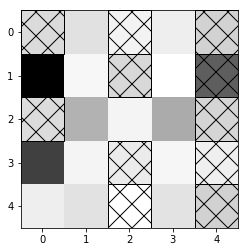

In [272]:
show_weights(0)

위의 은닉 뉴런은 왼편과 중간 줄의 가운데에서 큰 양의 값을 가지며,  
오른편으로는 큰 음의 값을 가진다.

게다가 bias도 제법 큰 절댓값을 가진 음수이므로, '찾고있는' 특정 입력값이 아닌 이상 강하게 활성화 되지 않는다.  
실제로, 그런 입력값에 대해서는 결과도 예측 가능하다.

In [273]:
left_column_only = [1, 0, 0, 0, 0] * 5
print(feed_forward(network, left_column_only)[0][0]) # 1.0

0.9999595246154831


In [274]:
center_middle_row = [0, 0, 0, 0, 0] * 2 + [0, 1, 1, 1, 0] + [0, 0, 0, 0, 0] * 2
print(feed_forward(network, center_middle_row)[0][0]) # 0.95

0.9541076270648262


In [275]:
right_column_only = [0, 0, 0, 0, 1] * 5
print(np.round(feed_forward(network, right_column_only)[0][0])) # 0.0

0.0


마찬가지로 아래의 2번 은닉 뉴런은 가로선을 좋아하지만,  
왼편과 오른편의 수직선은 좋아하지 않는다.

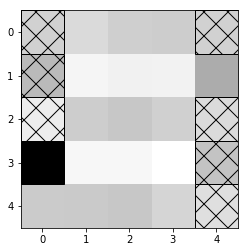

In [276]:
show_weights(2)

아래의 4번 은닉 뉴런은 가운데 가로선을 좋아하지만,  
오른편의 수직선은 좋아하지 않는 것으로 보인다.

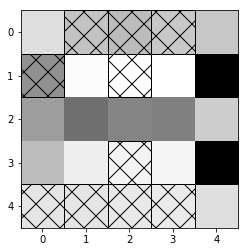

In [277]:
show_weights(4)

나머지 2개의 뉴런들은 해석하기가 쉽지 않다.

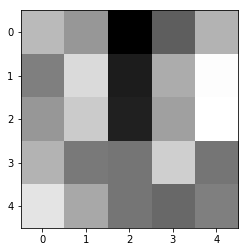

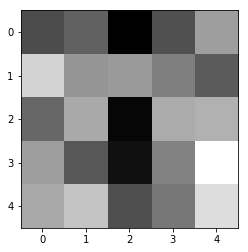

In [278]:
show_weights(1)
show_weights(3)

제멋대로 만든 숫자 3을 신경망에 넣으면?

In [280]:
my_three = [
    0,1,1,1,0,    # .@@@.
    0,0,0,1,1,    # ...@@
    0,0,1,1,0,    # ..@@.
    0,0,0,1,1,    # ...@@
    0,1,1,1,0     # .@@@.
]

In [281]:
hidden, output = feed_forward(network, my_three)

In [300]:
np.round(hidden, 3)

array([ 0.104,  1.   ,  1.   ,  1.   ,  0.   ])

은닉층의 결과값은 순서대로 다음과 같다,
1. network[0][0]의 값, (1, 4)때문에 어두워짐
2. network[0][1]의 값, (0, 2)와 (2, 2)의 영향이 큼
3. network[0][2]의 값, (3, 4)를 제외하고는 모두 양수
4. network[0][3]의 값, 다시 한번 (0, 2)와 (2, 2)의 영향이 큼
5. network[0][4]의 값, 중앙 행을 제외하고는 음수 혹은 0

이들은 network[-1][3]의 weight로 '숫자 3'의 출력 뉴런으로 전달된다.

In [295]:
np.round(network[-1][3], 2)

array([-11.53,  -2.18,   9.36,  -1.39, -11.55,  -1.94])

network[-1][3]의 값은 순서대로, 은닉층의 각 뉴런의 weight이고, 마지막은 bias의 weight이다.

따라서 뉴런은 최종적으로 다음의 식을 계산하고, 결과로 0.92를 반환한다.

sigmoid(.121 * -11.61 + 1 * -2.17 + 1 * 9.31 - 1.38 * 1 - 0 * 11.47 - 1.92)  
=> 책의 내용

일관되도록 은닉층의 결과에 weight를 곱하는 순서를 맞춰주고, 실제 결과를 대입해 보면,  
sigmoid(.104 * -11.53 + 1 * -2.18 + 1 * 9.36 + 1 * -1.39 + 0 * -11.55 - 1.94)

In [303]:
sigmoid(.121 * -11.61 + 1 * -2.17 + 1 * 9.31 - 1.38 * 1 - 0 * 11.47 - 1.92)

0.9194716562747247

In [305]:
sigmoid(.104 * -11.53 + 1 * -2.18 + 1 * 9.36 + 1 * -1.39 + 0 * -11.55 - 1.94)

0.9340652081228703

요약하자면, 은닉층은 25차원 공간을 5차원으로 축소했고,  
출력층은 5차원으로 축소된 공간의 결과값만 사용해서 최종 출력값을 계산했다.

my_three는 0번 은닉 뉴런을 아주 조금, 1번, 2번, 3번 은닉 뉴런을 강하게 활성화 시키고,  
4번 은닉 뉴런은 전혀 활성화 시키지 않는다.

최종적으로 출력층의 10개 뉴런은 그 다섯 개의 은닉 뉴런의 결과값만 이용해서,  
my_three가 자기 자신을 가리키는 숫자인지 판별한다.